### In this notebook the effects of filtering on the cross correlation are analysed

#### Importing libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift, rfft

#### Defining paths

In [2]:
data_path =  r"..\data\avstand_1.npz"

#### Defining Cross Correlation Parameters

In [3]:
numtaps = 1001
truncate_length = 60
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
band_width = 1000
frequencies = np.linspace(1000, 16000, 100)
sampling_rate = 204800 #Hz
num_samples = 1000

#### Loading data 

In [4]:
data = np.load(data_path)['data']

#### Defining the two system noise variables we will analyse in this notebook

In [5]:
sensor_1 = data[0][:num_samples]
sensor_2 = data[1][:num_samples]

#### Defining Cross Correlation Functions

In [6]:
filters = []
# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero="bandpass", window = "tukey")
    filters.append(h)

def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift

def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in tqdm(filters):
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)

        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12


#### GCC creation

In [7]:
GCC_12 = GCC(sensor_1, sensor_2)
GCC_11 = GCC(sensor_1, sensor_1)
GCC_22 = GCC(sensor_2, sensor_2)
GCC_21 = GCC(sensor_2, sensor_1)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 710.27it/s]


#### Creating the time_shifts 

In [8]:
dt = 1 / sampling_rate
time_shifts = np.arange(-num_samples*dt,num_samples*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)

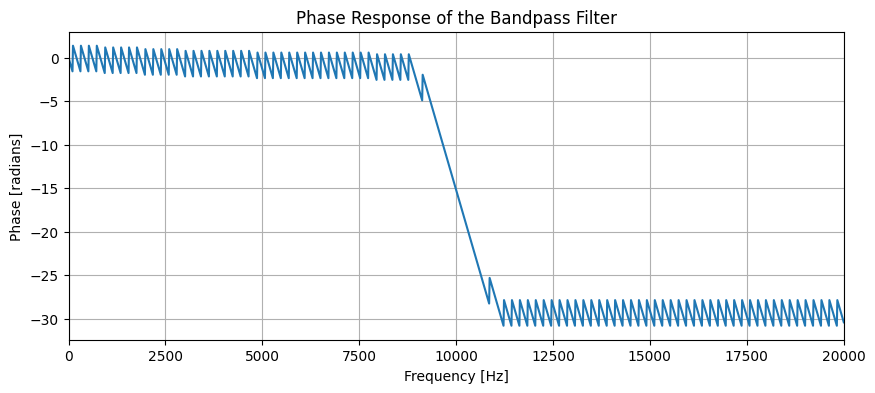

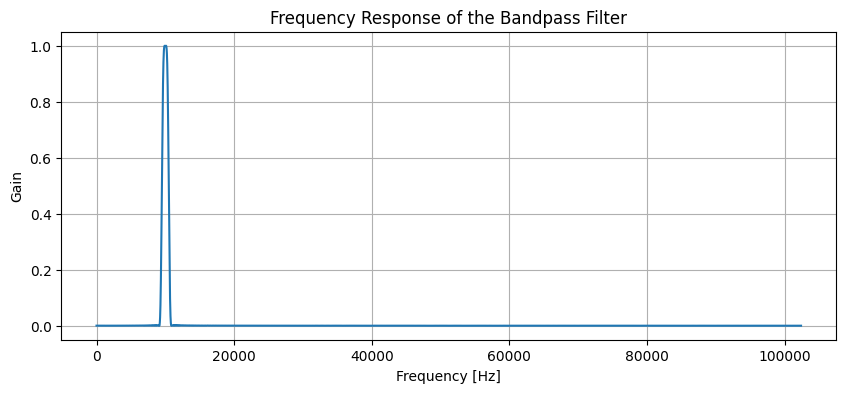

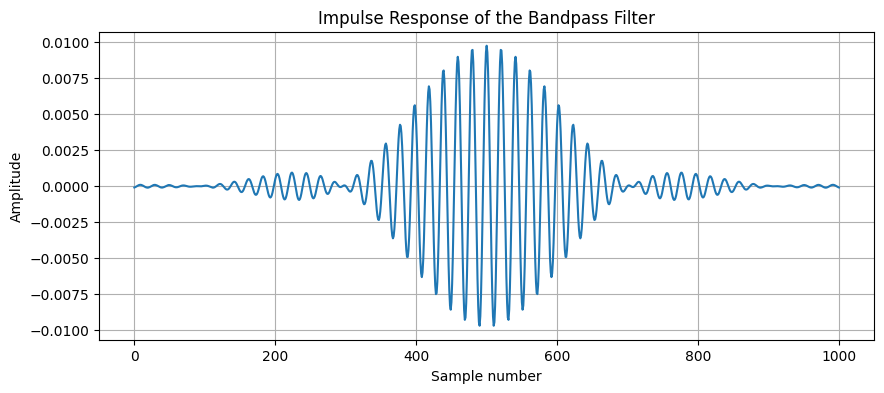

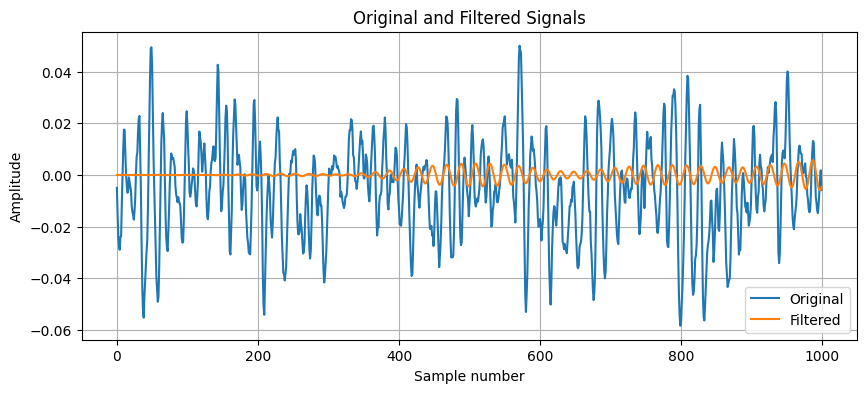

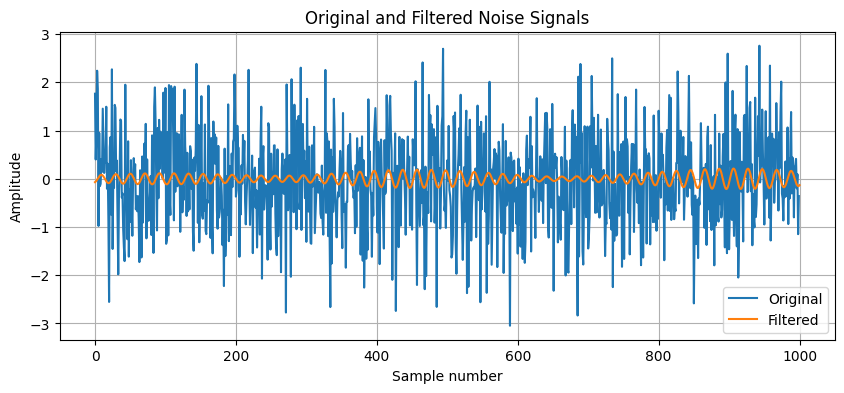

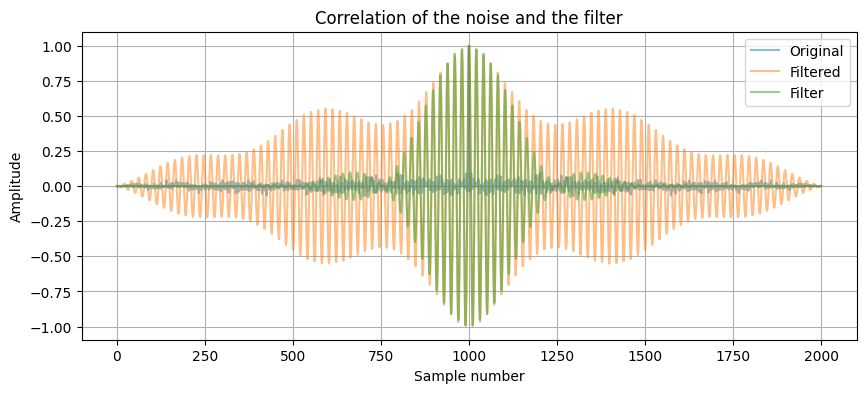

In [12]:
frequency_central = 10000
# Create the filter
filter_coefficients = signal.firwin(numtaps, 
                                    [frequency_central - band_width//2, frequency_central + band_width//2], 
                                    fs=sampling_rate, 
                                    pass_zero="bandpass")

# Calculate the impulse response of the filter
impulse = np.zeros(numtaps)  # Create an impulse signal
impulse[0] = 1  # Set the first sample to 1
impulse_response = signal.lfilter(filter_coefficients, 1, impulse)  # Apply the filter to the impulse signal

# plotting the phase response of the filter 
w, h = signal.freqz(filter_coefficients, worN=8000)
plt.figure(figsize=(10, 4))
# using unwrap 
plt.plot(0.5 * sampling_rate * w / np.pi, np.unwrap(np.angle(h)), '-')
plt.title('Phase Response of the Bandpass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.xlim(0, 20000)
plt.grid(True)
plt.show()

# Plot the frequency response
w, h = signal.freqz(filter_coefficients, worN=8000)
plt.figure(figsize=(10, 4))
plt.plot(0.5 * sampling_rate * w / np.pi, np.abs(h), '-')   
plt.title('Frequency Response of the Bandpass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid(True)
plt.show()

# Plot the impulse response
plt.figure(figsize=(10, 4))
plt.plot(impulse_response, '-')
plt.title('Impulse Response of the Bandpass Filter')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# convolving the filter with the signal 
filtered_sensor_1 = signal.lfilter(filter_coefficients, 1, sensor_1)
filtered_sensor_2 = signal.lfilter(filter_coefficients, 1, sensor_2)

# Plot the original and filtered signals
plt.figure(figsize=(10, 4))
plt.plot(sensor_1, label='Original')
plt.plot(filtered_sensor_1, label='Filtered')
plt.title('Original and Filtered Signals')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# Convolvin the filter with gaussian noise 

# Create a Gaussian noise signal
np.random.seed(0)  # Set the random seed for reproducibility
noise = np.random.normal(0, 1, num_samples)

# apply the filter by convolving the noise with the system response
filtered_noise = np.convolve(noise, impulse_response, mode='same')

# Plot the original and filtered noise signals
plt.figure(figsize=(10, 4))
plt.plot(noise, label='Original')
plt.plot(filtered_noise, label='Filtered')
plt.title('Original and Filtered Noise Signals')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,1,figsize = (10,4))

cc_noise = np.correlate(noise, noise, mode='full')
cc_noise = cc_noise / np.max(np.abs(cc_noise))

cc_filtered_noise = np.correlate(filtered_noise, filtered_noise, mode='full')
cc_filtered_noise = cc_filtered_noise / np.max(np.abs(cc_filtered_noise))

cc_filter = np.correlate(impulse_response, impulse_response, mode='full')
cc_filter = cc_filter / np.max(np.abs(cc_filter))


ax.plot(cc_noise, label='Original', alpha=0.5)
ax.plot(cc_filtered_noise, label='Filtered', alpha=0.5)
ax.plot(cc_filter, label='Filter', alpha=0.5)
ax.set_title('Correlation of the noise and the filter')
ax.set_xlabel('Sample number')
ax.set_ylabel('Amplitude')
ax.legend()
ax.grid(True)
plt.show()



#### Plotting the magnitude and fase information of the system signal



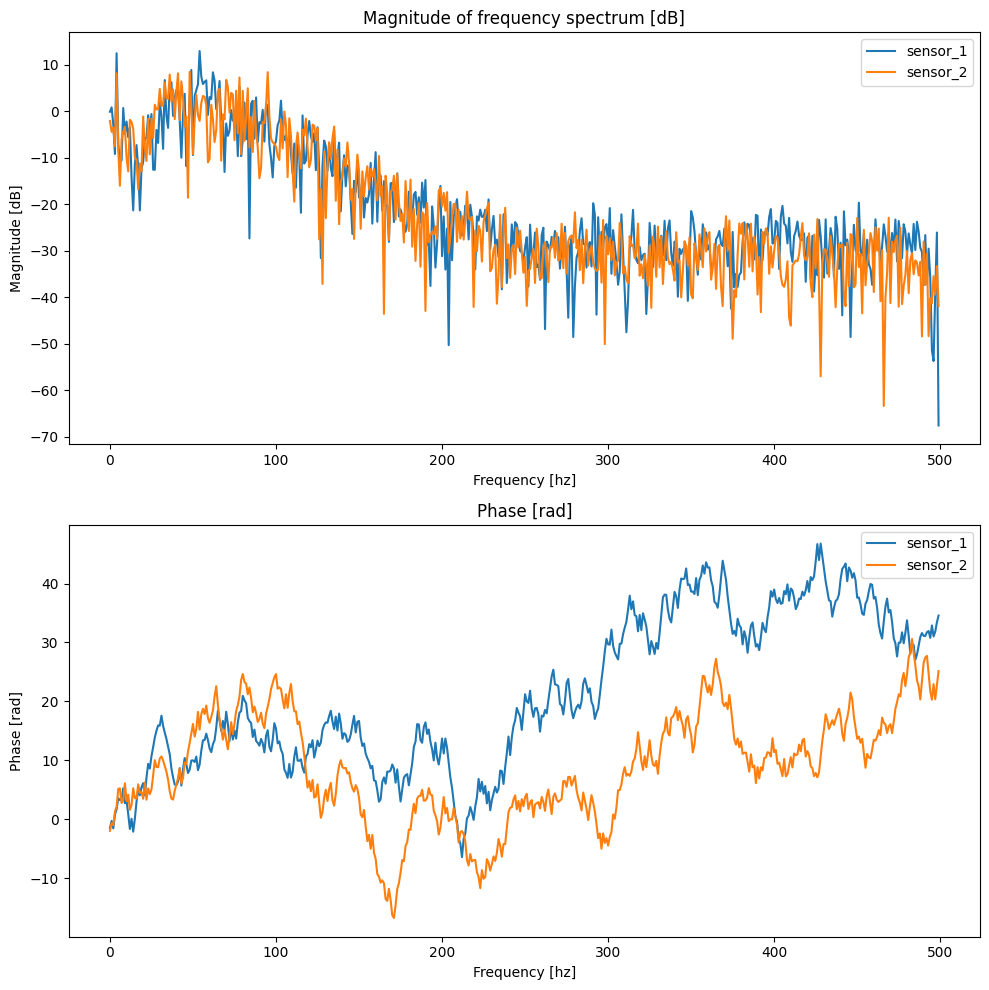

In [54]:
fft_sensor_1 = rfft(sensor_1)[1:]
fft_sensor_2 = rfft(sensor_2)[1:]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax = ax.ravel()

ax[0].plot(np.log10(np.abs(fft_sensor_1))*20, label = "sensor_1")
ax[0].plot(np.log10(np.abs(fft_sensor_2))*20, label = "sensor_2")
ax[0].set_title("Magnitude of frequency spectrum [dB]")
ax[0].set_xlabel("Frequency [hz]")
ax[0].set_ylabel("Magnitude [dB]")


ax[1].plot(np.unwrap(np.angle(fft_sensor_1)), label = "sensor_1")
ax[1].set_title("Phase [rad]")
ax[1].plot(np.unwrap(np.angle(fft_sensor_2)), label = "sensor_2")
ax[1].set_xlabel("Frequency [hz]")
ax[1].set_ylabel("Phase [rad]")


ax[0].legend()
ax[1].legend()

fig.tight_layout()



#### Cross Correlation of the system noise for different frequency filters

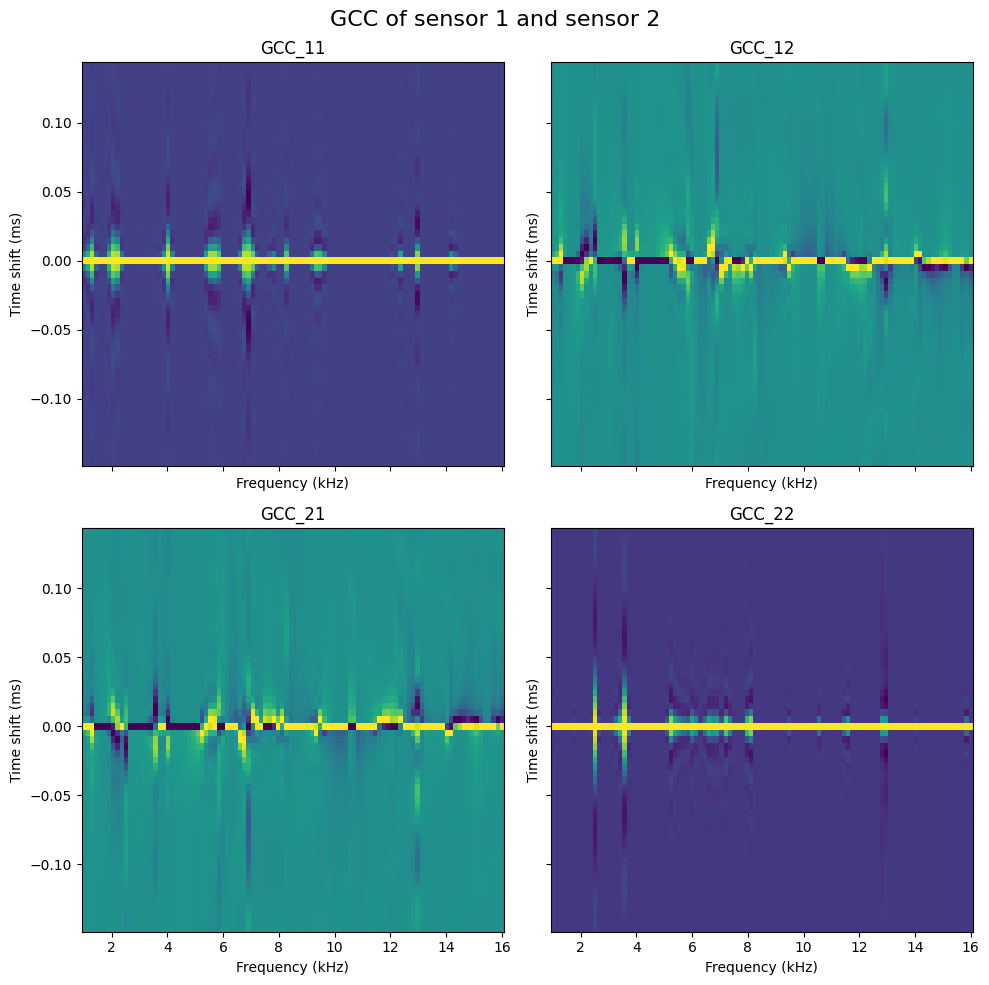

In [55]:
fig, ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()


ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12.T, shading='auto')
ax[1].set_title('GCC_12')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')

ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_11.T, shading='auto')
ax[0].set_title('GCC_11')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')

ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_22.T, shading='auto')
ax[3].set_title('GCC_22')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')

ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_21.T, shading='auto')
ax[2].set_title('GCC_21')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')


fig.suptitle('GCC of sensor 1 and sensor 2', fontsize=16)

fig.tight_layout()
